Installs and imports

In [38]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

Download and process dataset

In [53]:
apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

train_dataset = CIFAR10(root= "./",train=True, download=True,transform=apply_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_dataset = CIFAR10(root= "./",train=False, download=True,transform=apply_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

mapp = np.array(['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

Files already downloaded and verified
Files already downloaded and verified


Training constants

In [40]:
classes = 10
input_dim = 784

num_users = 8
rounds = 1
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

Create client datasets

In [41]:

train_idcs = np.random.permutation(len(train_dataset))
test_idcs =  np.random.permutation(len(test_dataset))
train_labels = np.array(train_dataset.targets)

In [42]:

class CustomSubset(Subset):
    '''A custom subset class with customizable data transformation'''
    def __init__(self, dataset, indices, subset_transform=None):
        super().__init__(dataset, indices)
        self.subset_transform = subset_transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]

        if self.subset_transform:
            x = self.subset_transform(x)

        return x, y

In [44]:
def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    n_classes = train_labels.max()+1
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)

    class_idcs = [np.argwhere(train_labels[train_idcs]==y).flatten()
           for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs



client_idcs  = split_noniid(train_idcs, train_labels,1, num_users)


client_data = [CustomSubset(train_dataset, idcs) for idcs in client_idcs]
test_data = CustomSubset(test_dataset, test_idcs, transforms.Compose([transforms.ToTensor()]))

In [50]:
print(min(train_labels))
print(min(train_labels)-0.5)

[6 9 9 ... 9 1 1]
0
-0.5


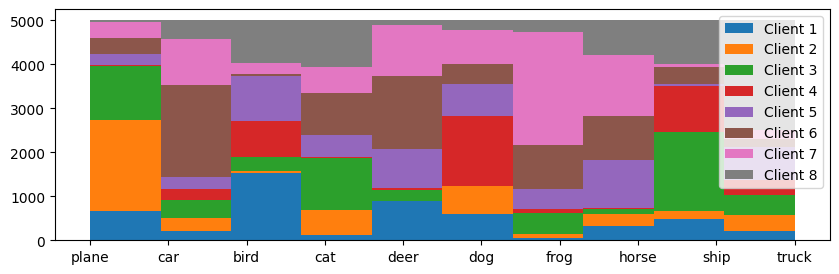

In [55]:
plt.figure(figsize=(10,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True,
        label=["Client {}".format(i+1) for i in range(num_users)])
plt.xticks(np.arange(10), mapp)
plt.legend()
plt.show()

Define model

In [ ]:
class CNNCifar(nn.Module):
    def __init__(self, num_classes):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

global_model = CNNCifar(10)

FLL training